# NASA NeoWs API: Potentially Hazardous Asteroids

Find out how many potentially hazardous asteroids were present each month in a given date range.

---
## Objective of NASA API Portal

To make NASA data eminently accessible to application developers.

## NeoWs API

Provides near earth Asteroid information. Useful for anyone curious about astronomical happenings.

In [1]:
import calendar
from collections import defaultdict
from datetime import datetime, timedelta
import os
import requests

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def get_date_range():
    """
    Solicit user for start date and end date.
    
    Args:
        None
    
    Returns:
        tuple: tuple containing start date and end date
    """
    
    start_date = datetime.fromisoformat(input('Enter start date (YYYY-MM-DD): ')).date()
    end_date = datetime.fromisoformat(input('Enter end date (YYYY-MM-DD): ')).date()
    assert end_date > start_date, 'End date must be greater than start date.'
    assert (end_date - start_date).days <= 720, 'Maximum date range is 2 years.'
    
    return start_date, end_date


def _extract_data(near_earth_objects):
    """
    Creates dictionary for asteroid properties 
    and fills dictionary with data from response.
    
    Args:
        near_earth_objects(dict): dict of contents of 'near_earth_objects' key of response
    
    Returns:
        dict: dict of useful portions of the data
    """
    keys_to_check = [
        'name',
        'date',
        'close_approach_data',
        'estimated_diameter',
        'is_potentially_hazardous_asteroid'
    ]
    # make an dictionary with keys of useful features
    asteroid_dict = defaultdict(list)

    # iterate through each day of the span of days selected
    for date in near_earth_objects:
        # iterate through the list of entries for the day
        for entry in near_earth_objects[date]:
            # iterate through each key of the dictionary making up each entry
            for key in keys_to_check:
                # seek out relevant portions of data
                if key == 'close_approach_data':
                    asteroid_dict['close_approach_date'].append(
                        entry[key][0]['close_approach_date'])
                    asteroid_dict['relative_velocity_mph'].append(
                        entry[key][0]['relative_velocity']['miles_per_hour'])
                    asteroid_dict['miss_distance_miles'].append(
                        entry[key][0]['miss_distance']['miles'])
                elif key == 'estimated_diameter':
                    asteroid_dict['est_diameter_max_feet'].append(
                        entry[key]['feet']['estimated_diameter_max'])
                elif key == 'date':
                    asteroid_dict['date'].append(date)
                else:
                    asteroid_dict[key].append(entry[key])
    
    return dict(asteroid_dict)


def get_data_dictionary(start, end):
    """
    Make API call and extract select data from response.
    Start and end are at most 7 days apart.
    
    Args:
        start(datetime.date): start date of query
        end(datetime.date): end date of query
        
    Returns:
        dict: dict of select portions of data from API response
    """
    path = 'https://api.nasa.gov/neo/rest/v1/feed?start_date={}&end_date={}&api_key={}'
    url = path.format(start, end, os.environ['NASA_NEOWS_API_KEY'])
    
    # get data
    print('\rQuerying for {} to {}...'.format(start, end), end='', flush=True)
    rsp = requests.get(url)
    # parse JSON reponse and grab the contents of 'near_earth_objects' key
    neo = rsp.json()['near_earth_objects']
    # make a filtered dictionary out of the contents of 'near_earth_objects' key
    asteroid_dict = _extract_data(neo)
    
    return asteroid_dict


def format_df(df):
    """
    Various formatting steps to apply to dataFrame.
    
    Args:
        df(pandas.DataFrame): unformatted dataFrame 
        
    Returns:
        df(pandas.DataFrame): formatted dataFrame
    """
    df['year'], df['month'], df['day'] = zip(*df.close_approach_date.str.split('-'))
    for col in ['year', 'month', 'day']:
        df[col] = df[col].astype(int)
    for col in ['est_diameter_max_feet', 'relative_velocity_mph', 'miss_distance_miles']:
        df[col] = df[col].astype(float)
    df.drop(columns=['date'], inplace=True)
    df.rename(columns={'name': 'asteroid_name'}, inplace=True)
    df.set_index('asteroid_name', inplace=True)
    
    return df


def plot_df(df, start, end):
    """
    Plot the dataFrame to show number of potentially hazardous asteroids per month/year.
    
    Args:
        df(pandas.DataFrame): formatted dataFrame
        start(datetime.date): start date of entire query range
        end(datetime.date): end date of entire query range
        
    Returns:
        None
    """
    # filter for potentially hazardous asteroids
    df = df[df['is_potentially_hazardous_asteroid']]
    grouped_df = df.groupby(['year','month'])
    groups = grouped_df.groups
    grouped_df = grouped_df.size()
    plot = grouped_df.plot(kind='bar', width=1.0, edgecolor='black', figsize=(10,10))
    xticks = ['{} {}'.format(calendar.month_abbr[int(x[1])], x[0]) for x in groups.keys()]
    title = 'Number of Potentially Hazardous Asteroids\nPer Month From {} to {}'
    title = title.format(start, end)
    for i, v in enumerate(grouped_df.values):
        plot.text(x=i, y=v+(max(grouped_df.values)/100), s=str(v))
    plot.set_xticklabels(xticks, rotation=45)
    plot.set_xlabel('')
    plot.set_ylabel('Frequency\n', fontsize=12)
    plot.set_title(title, fontsize=16)

Enter start date (YYYY-MM-DD): 2019-01-01
Enter end date (YYYY-MM-DD): 2019-05-31
Querying for 2019-05-25 to 2019-05-31...

,relative_velocity_mph,miss_distance_miles,est_diameter_max_feet
is_potentially_hazardous_asteroid,,,
False,"28,276","18,757,964",848
True,"37,817","24,667,156","2,122"


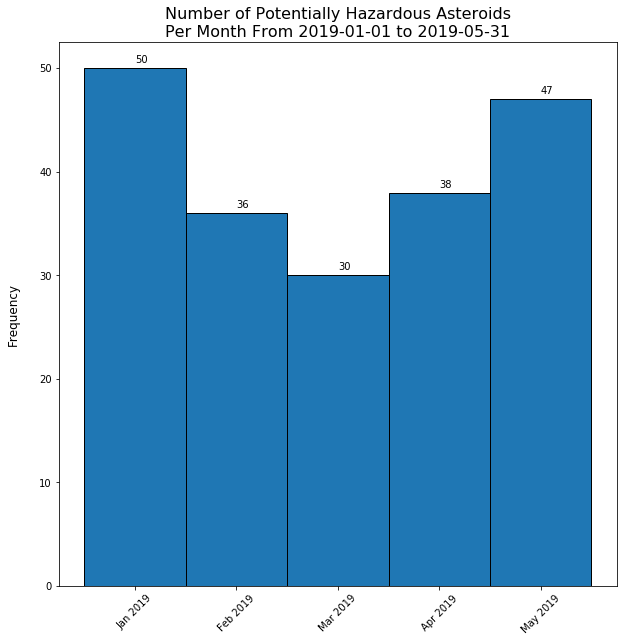

In [3]:
if __name__ == '__main__':
    start_date, end_date = get_date_range()
    date_difference = (end_date - start_date).days
    num_weeks = int(date_difference/7)
    num_days = date_difference%7
    
    start, end = start_date, start_date + timedelta(days=num_days)
    asteroid_dfs = [pd.DataFrame(get_data_dictionary(start, end))]
    for _ in range(num_weeks):
        start, end = end + timedelta(days=1), end + timedelta(days=7)
        asteroid_dfs.append(pd.DataFrame(get_data_dictionary(start, end)))

    asteroid_df = pd.concat(asteroid_dfs, axis=0)
    asteroid_df = format_df(asteroid_df)
    # compare stats between potentially hazardous and non-potentially hazardous asteroids
    display(
        asteroid_df.groupby(
        ['is_potentially_hazardous_asteroid']
        ).mean()[[
            'relative_velocity_mph',
            'miss_distance_miles',
            'est_diameter_max_feet'
        ]].apply(lambda s: s.apply(lambda x: '{:,.0f}'.format(x)))
    )
    plot_df(asteroid_df, start_date, end_date)